## What makes a happy citizen? 
### - An experiment to explain World Happiness Index with Maslow's Pyramid of Needs
<br/>



<div>
<img src='https://srv.latostadora.com/designall.dll/piramide_de_maslow_actualizada--i:14138524893214138520;x:20;w:520;m:1.jpg' width="350"/>
</div>


As inspired by the legendary theory Maslow's Pyramid of Needs, which explains the structure of human needs in a simple pyramid, we will gather some national level indicators from 2014 to 2018 based on the categories from this pyramid, in hopes of finding out what factors and how they contribute to the life evaluation of a citizen. 

We selected some national level indicators based on each category in the pyramid and will later investigate the correlation between each indicator and happiness score.

#### Questions: 

<center><b>What factors contribute more in our happiness?<b></center>

<center><b>If we rank the impact of these factors, will the ranking follow the same sequence as pyramid of needs?<b></center>

#### Categories, Indicators and data sources:

- **Basic Needs**
    - 1. GDP per capita - PPP (current international$), Worldbank
    - 2. Life expectancy at birth, total (years), Worldbank
    - 3. Domestic general government health expenditure (% of current health expenditure), World Health Organisation
- **Safety Needs**
    - 4. Murder(death per 100K people), Worldbank
- **Social Needs**
    - 5. World giving index, Knoema (Gallup world poll)
- **Esteem Needs** 
    - 6. Civil Liberties Index, Gapminder
    - 7. Gender Inequality (Gini Coefficient), Gapminder
    - 8. Democracy index, Gapminder
- **Self-actualization** 
    - 9. School Enrollment, tertiary (% gross), Worldbank
- **Wifi (Fun Experiment :))**
    - 10. Percetage of population with Internet access, Worldbank
    

Our hypothesis are:

1. Indicators corresponding to categories in the lower level of the pyramid of needs will have a stronger coorelation with happiness score. 
2. An improvement of the indicators corresponding to categories in the lower level of the pyramid will have a higher impact on the increase of happiness score, compared to those categories in a higher level. 

In this jupyter notebook, we will gather data for the indicators we selected, prepare and explore the data. We will find out whether our hypothesis 1 is correct in the end. 

Later on data will be exported to the last notebook for modelling. We will be able to prove our hypothesis 2 and solve our main questions, after we finalize our model.


### Approaches 

1. Prepare dataframes

   For each dataset of each indicator:
   - 1.0 Load and read data 
   - 1.1 Data Cleaning and Manipulation <br/>


2. Combine all indicatiors and world happiness score to one dataframe
3. [Data Exploration of each indicator](#3.Data-Exploration)
 - 3.1 [Distribution of indicators each year](#3.1-Distribution-of-indicators-each-year)
 - 3.2 [Yearly trend for each indicators](#3.2-Yearly-trend-for-each-indicators)
 - 3.3 [Region Performance](#3.3-Region-Performance)
 - 3.4 [Correlations between each indicator and happiness score](#3.4-Correlations-between-each-indicator-and-happiness-score)
 - 3.5 [Correlations among indicators](#3.5-Correlations-among-indicators)
 


In [1]:
import pandas as pd
import numpy as np
import re
import country_converter as coco

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import altair as alt
alt.renderers.enable('notebook')

import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

pd.set_option('display.max_rows', 500)

## 1. Preparing dataframes

For each dataset of each indicator:
- Load and read data
- Data Cleaning and Manipulation

**Before starting the process, we will define several functions to clean reshape dataframe and handle missing values**
- Data we need is from 2014 to 2018 but we will need the data before this time frame to impute missing values. 
- There are some missing values and we would like to take the latest value availabla for a particular country
- We will change the 'year' column to datetime value in order to use ffill() function to impute with latest value

In [2]:
# Define a function to melt the dataframe
def melt_table(df,col):
    df.columns = map(str.lower,df.columns)
    return df.melt('country').rename({'variable':'year',
                                      'value':col},axis=1)

In [3]:
# Define a function fill missing values with latest data
def fill_latest_value(df,col):
    df['year'] = pd.to_datetime(df['year'])
    df = df.sort_values(by='year').set_index(['year'])
    df[col] = df.groupby("country").transform(lambda x: x.ffill())
    df.reset_index(inplace=True)
    df['year'] = df['year'].dt.year
    return df

In [4]:
# Define a function fill missing values with region value

def fill_region_mean(df, col):
    countries = df['country'].tolist()
    converter = coco.CountryConverter()
    df['region'] = converter.convert(names = countries, src = 'regex', to = 'unregion')

    mean_region = df.groupby('region').mean()[col].to_dict()
    mean_region

    df[col] = (df.set_index('region')[col]
                  .fillna(mean_region,axis='index')
                  .reset_index(drop=True))
               
    df=df.drop(columns='region')
    return df

In [5]:
# Define a function fill missing values with global mean
def fill_global_mean(df, col):
    return df.fillna(df[col].mean())

In [6]:
# We need only 2014-2018 data, also need to rename the value to index name
def filter_data(df,df_name):
    df = (df[(df['year']>=2014) & (df['year']<=2018)].reset_index(drop=True))                          
    return df

In [7]:
# Use country converter package to align all country names
def convert_country_name(df):
    
    #Channel Island is not found in country converter and it is not in world happiness report as well. 
    #We will drop it to avoide multiple warnings generated by country converter for each dataframe 
    df = df[df['country']!='Channel Islands'].reset_index(drop=True)
    
    countries = df['country'].tolist()
    converter = coco.CountryConverter()
    df['country'] = converter.convert(names = countries, src = 'regex', to = 'name_short')
    return df

In [8]:
# There are still some missing values as some countries had never provided gdp data. We will drop those countries
def drop_no_data_countries(df):
    to_drop_countries = df[df.isnull().any(axis=1)].groupby('country').count().index.tolist()
    to_drop_index = df[df['country'].isin(to_drop_countries)].index.tolist()
    return df.drop(to_drop_index).reset_index(drop=True)
    

In [9]:
# Several datasets are from world bank that follow the same format, define a function to format them before reshaping the dataframe
def world_bank_pre_clean(df):
    # Rename columns and drop uncessary columns and rows so we can use the above defined functions
    df = (df.rename({'Country Name':'country'},axis=1)
            .drop(['Series Name','Series Code','Country Code'],axis=1)
            .drop(range(217,222)))
    
    # Remove the unecessary part [YR...] for years 
    df = df.rename(columns=lambda x: re.sub('\[\w*\d*\]','',x))
    
    # Replace strings that indicate 'No Data' to NaN value
    df.iloc[:,1:] = df.iloc[:,1:].apply(pd.to_numeric,errors='coerce')
    return df

In [10]:
# Define a function to combine the above tasks for dataset that are not from world bank
def convert_df(df,col,worldbank=False):
    
    if worldbank==True:
        df = world_bank_pre_clean(df) 
        
    df = melt_table(df,col)
    df = convert_country_name(df)
    df = fill_latest_value(df,col)
    df = fill_region_mean(df,col)
    df = fill_global_mean(df,col)
    df = filter_data(df,col)
    return df

**0. World happeinss index (WHI)**

In [11]:
whi = pd.read_csv('./data/whi/df_all.csv')

**1. GDP per capita, PPP (current international $)**

In [12]:
gdp = pd.read_csv('./data/worldbank/GDP.csv')
gdp = convert_df(gdp,'gdp',worldbank=True)

Remarks: <br/>
Channel Islands is not in the happiness report and therefore will be dropped later when we merge it with happiness score dataframe. Ignored the warning. 

**2. Domestic general government health expenditure (% of current health expenditure) (GHE)**

In [13]:
ghe = pd.read_csv('./data/worldbank/general_government_health_expense.csv')
ghe=convert_df(ghe,'ghe',worldbank=True)

**3. Life expectancy at birth, total (years) (LE)**

In [14]:
le = pd.read_csv('./data/worldbank/life_expectancy.csv')
le=convert_df(le,'le',worldbank=True)

In [15]:
le.shape

(1080, 3)

**4. Murder (death per 100K people) (MU)**

In [16]:
mu = pd.read_csv('./data/worldbank/intentional_homicides.csv')
mu=convert_df(mu,'mu',worldbank=True)

In [17]:
mu.shape

(1080, 3)

**5. World giving index, Knoema (Gallup world poll) (WGI)** 
- Collected from Knoema API

In [18]:
import knoema

raw_df = knoema.get('WDGIVIND2018', timerange='2010-2018', frequency='A', 
Location=('UG;AU;NZ;KZ;KG;TJ;TM;UZ;CN;HK;JP;MN;KR;TW;AM;AZ;BH;CY;GE;IQ;IL;JO;KW;LB;KN.C1;SA;PS;SY;QA;AE;YE;BT;AF;BD;IN;IR;NP;PK;LK;KH;ID;LA;MY;MM;KN.C3;PH;SG;TH;VN;BY;BG;CZ;HU;PL;MD;RO;RU;SK;UA;AT;BE;FR;DE;GM;LU;NL;CH;DK;EE;FI;IS;IE;LV;LT;NO;SE;GB;AL;BA;HR;GR;IT;KN.C2;MT;ME;PT;RS;SI;ES;MK;CM;CF;TD;CG;CD;GA;BI;KM;ET;KE;MG;MW;MU;MZ;RW;KN.SI;TZ;ZM;ZW;BJ;BF;CI;GH;GN;LR;ML;MR;NE;NG;SN;SL;TG;TR;DZ;EG;LY;MA;SD;SS;TN;AO;BW;LS;NA;ZA;BZ;CR;SV;GT;HN;MX;NI;PA;DO;HT;JM;PR;TT;CA;US;AR;BO;BR;CL;CO;EC;PY;PE;SR;UY;VE'), Indicator='KN.A1', Measure='KN.M2')

In [19]:
wgi = raw_df.copy()

wgi = (wgi.transpose()
      .reset_index().drop(['Indicator','Measure','Frequency'],axis=1)
      .rename({'Location':'country'},axis=1))

wgi.columns = ['country','2013','2014','2015','2016','2017','2018']

# Nagorno-Karabakh Region cannot be converted by country converter and is not in happiness report 
# Drop this region to avoid multiple warnings from country converter
wgi = wgi[wgi['country']!='Nagorno-Karabakh Region'].reset_index(drop=True)

wgi = convert_df(wgi,'wgi')

**6. Civil Liberties Index (CLI)**

In [20]:
cli = pd.read_csv('./data/gapminder/cliberities_fh.csv')
cli = convert_df(cli,'cli')

**7. Gender Inequality (Gini Coefficient) (GINI)**

In [21]:
gini = pd.read_csv('./data/gapminder/gini.csv')
gini = convert_df(gini,'gini')

In [22]:
gini.shape

(975, 3)

**8. Democracy index (DI)**

In [23]:
di = pd.read_csv('./data/gapminder/demox_eiu.csv')
di = convert_df(di,'di')

In [24]:
di.shape

(820, 3)

**9. Gross enrolment ratio, tertiary, both sexes (%) (GER)**
- Total enrollment in tertiary education (ISCED 5 to 8), regardless of age, expressed as a percentage of the total population of the five-year age group following on from secondary school leaving. UNESCO Institute for Statistics
- Percertage can be over 100% as the base of the ratio is is the total population of a five-year age group leaving secondary school. It can happen that students only enroll in tertiary education 5 years after secondary school. 

In [25]:
ger = pd.read_csv('./data/worldbank/tertiary_education.csv')

In [26]:
# Rename a column name to use the defined function for converting dataframe
ger = ger.rename({'Series':'Series Name'},axis=1)

ger = convert_df(ger,'ger',worldbank=True)

In [27]:
ger.shape

(1080, 3)

**10. Percentage of population with internet access (INTERNET)**

In [28]:
internet = pd.read_csv('./data/worldbank/internet_population.csv')

internet = convert_df(internet,'internet',worldbank=True)

In [29]:
internet.shape

(1080, 3)

## 2. Combine all indicatiors and world happiness score to one dataframe

In [30]:
df = (whi
      .merge(gdp, how='inner',on=['country','year'])
      .merge(ghe, how='inner',on=['country','year'])
      .merge(le, how='inner',on=['country','year'])
      .merge(mu, how='inner',on=['country','year'])
      .merge(wgi, how='inner',on=['country','year'])
      .merge(cli, how='inner',on=['country','year'])
      .merge(gini, how='inner',on=['country','year'])
      .merge(di, how='inner',on=['country','year'])
      .merge(ger, how='inner',on=['country','year'])
      .merge(internet, how='inner',on=['country','year']))

In [31]:
# Renaming columns to be more descriptive and to facilitate plotting
df = df.rename({'year':'Year',
                'country': 'Country',
                'continent': 'Continent',
                'region' : 'Region',
                'happiness rank': 'Happiness Rank',
                'happiness score': 'Happiness Score',
                'gdp' : 'Income(GDP)',
                'ghe': 'Covered health expense',
                'le' : 'Life Expectancy',
                'mu' : 'Murder(death per 100K people)',
                'wgi' : 'World giving index',
                'cli': 'Civil Liberties Index',
                'gini': 'Gender Inequality',
                'di' : 'Democracy Index',
                'ger' : 'Tertiary Education',
                'internet' : 'Internet Access'},axis=1)   

In [32]:
# There are in total 739 observations after merging all the datasets
df.shape

(739, 16)

## 3.Data-Exploration

### 3.1-Distribution-of-indicators-each-year

Observations:
1. Happiness Score was more normally distributed and tending to become more right-skewed since then. 
2. GDP has been consistently strongly left-skewed throughout the years. 50% of the global population is earning lower than 75000USD per year while the top 25% of the population is earning at least 22000USD per year. The difference is big. 
3. Gini Coefficient has also a tendency to become right-skewed, meaning that income inequality has a tendency to increase. 

In [33]:
indicators = [col for col in df.columns.tolist() 
              if col not in ['Year','Country','Continent','Region','Happiness Rank']]

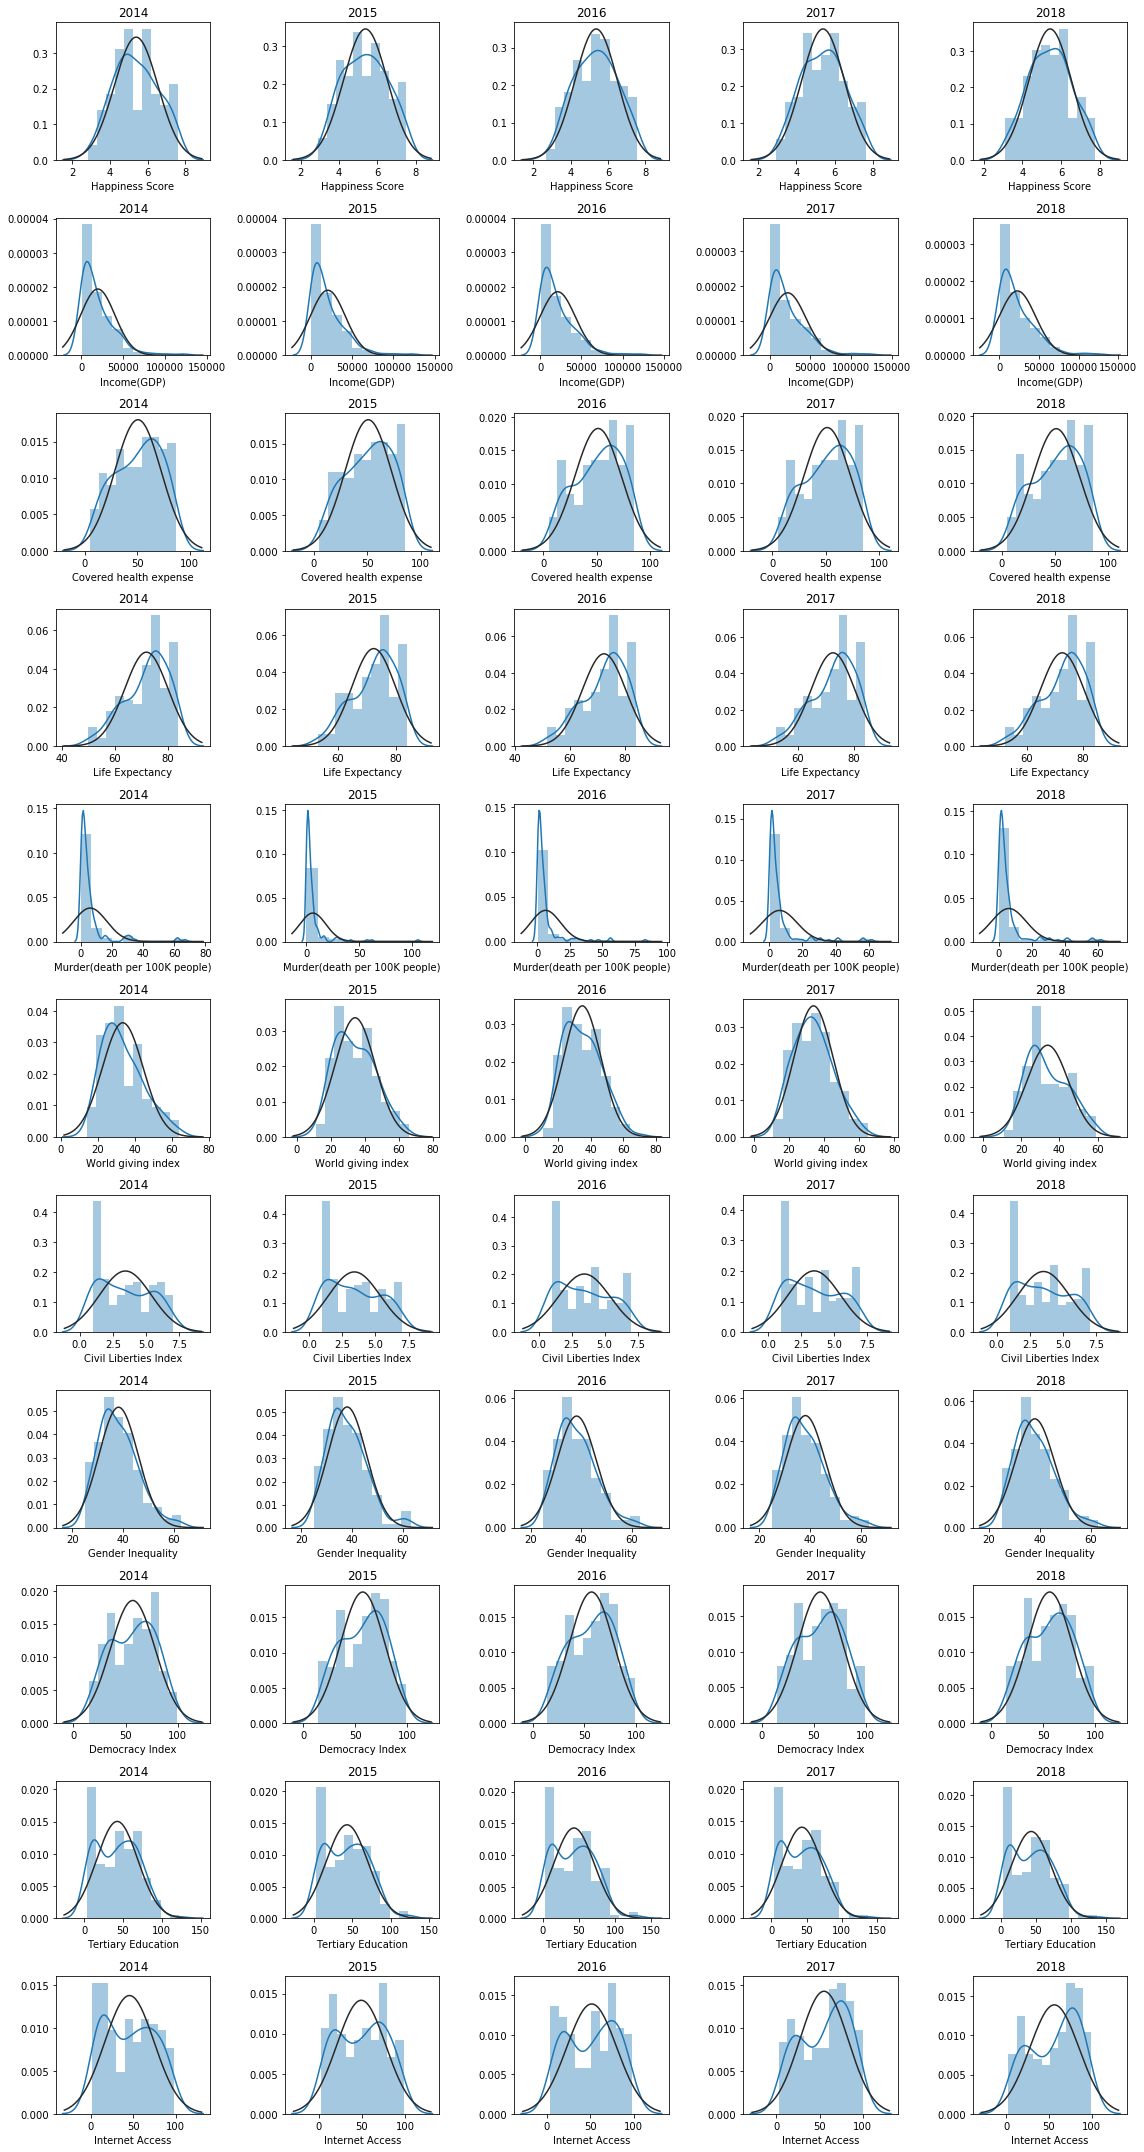

In [34]:
fig, ax = plt.subplots(nrows=11, ncols=5, figsize=(16,30));

row=0
for index in indicators:
    col=0
    for year in df['Year'].unique().tolist():
        sns.distplot(df[df['Year']==year][index],fit=stats.norm,bins=10,ax=ax[row,col])
        ax[row,col].set_title(year)
        plt.tight_layout()
        col+=1
    row+=1  


### 3.2-Yearly-trend-for-each-indicators

Oberservations:

1. Happiness Score in Europe has continously increased and had passed the score in America in 2015. 
2. Number of Homicides in Americas is generally much higher than other continent by at least 10 per year. We can see an increase in 2015 and the number slowly went down until 2017. 
3. World giving index, measuring how active a citizen is in charity and community work, is consistently highest on average in countries in Oceania. 

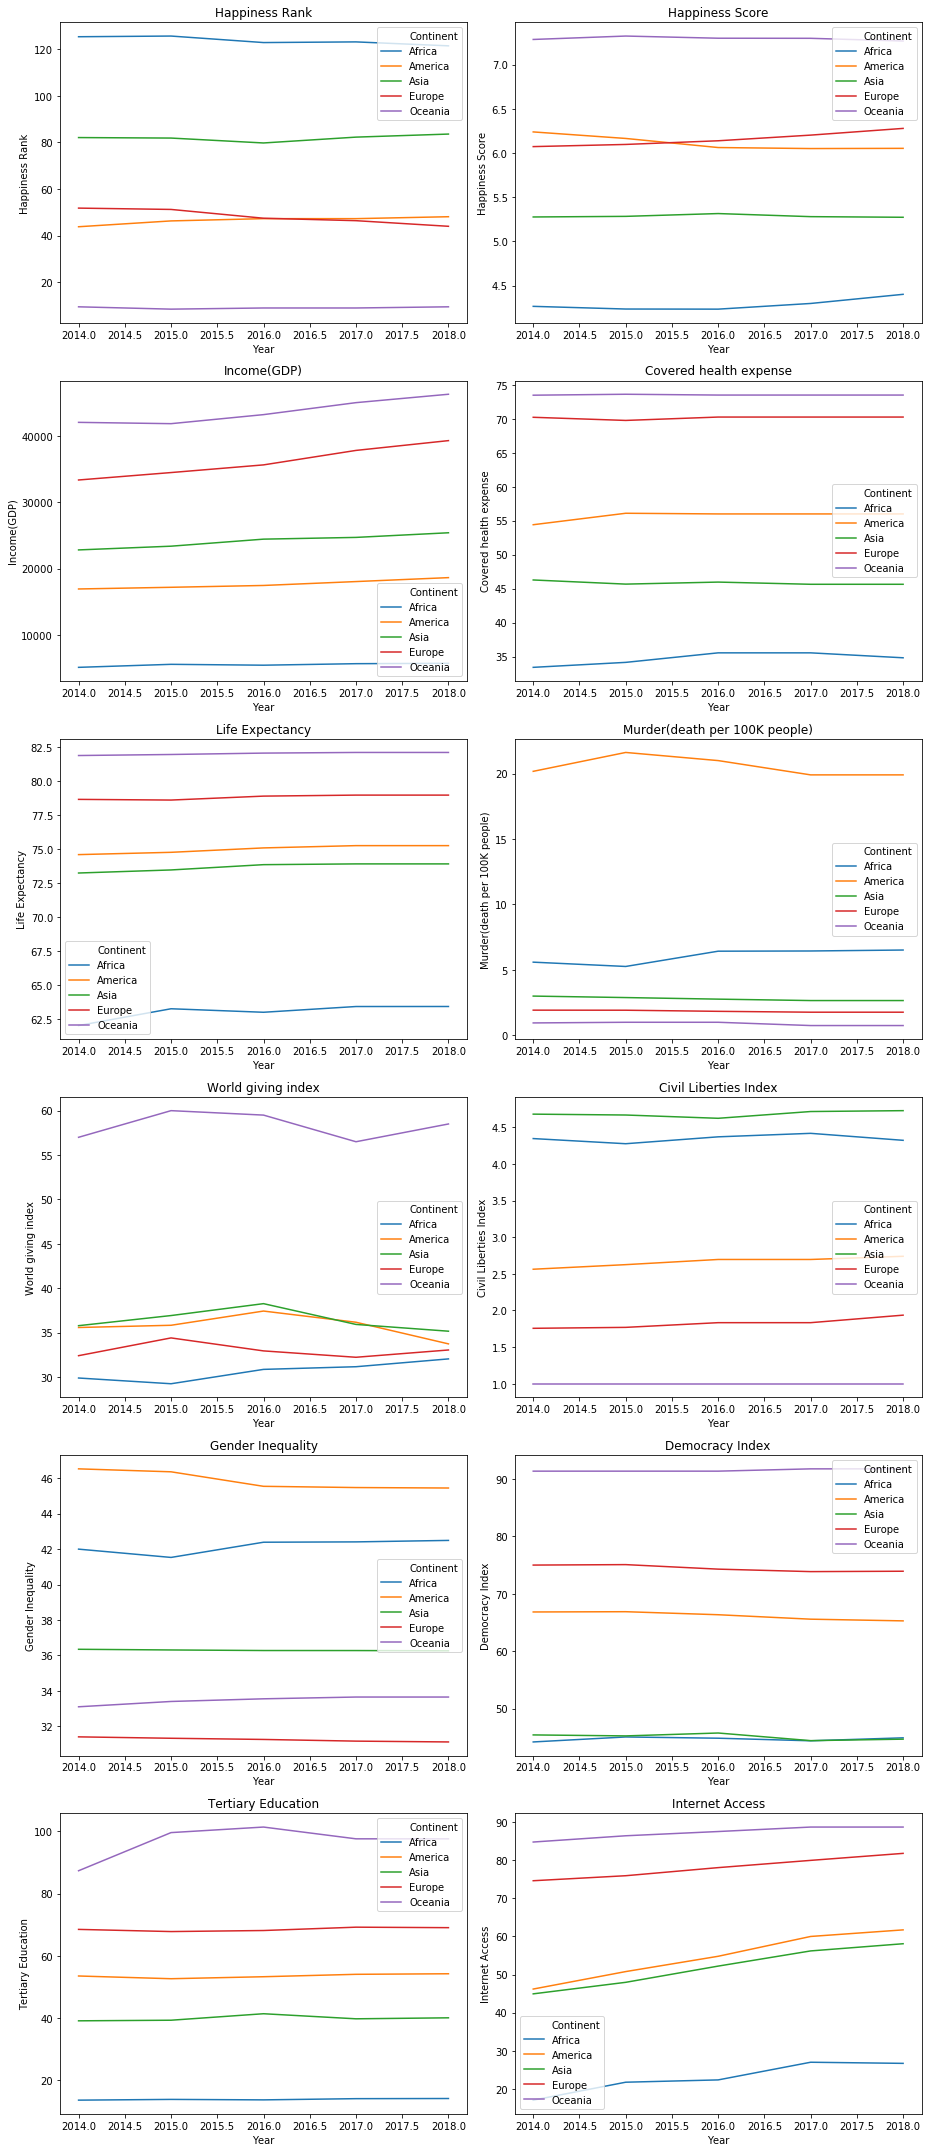

In [35]:
indicators = [col for col in df.columns.tolist() 
              if col not in ['Year','Country','Continent','Region']]
fig, ax = plt.subplots(nrows=6,ncols=2, figsize=(13,30))

i=0
for row in range(6):
    for col in range(2):
        sns.lineplot(x="Year", 
                     y=indicators[i],
                     hue='Continent',
                     data=df.groupby(['Year','Continent']).mean().reset_index(),
                     ax=ax[row,col],
                     markers=True
                    ).set_title(f'{indicators[i]}')
        i+=1
        plt.tight_layout()

### 3.3-Region-performance

- We would like to know how a region perform in different areas of life. Since the indicators all come with different scales, we will use min-max-scaler to convert them to the same scale (0 to 1). With min-max-scale, we will see close the country is to the min or max value in each indicator. We will compare the mean of indicators of each region and we will know which area a region perform better.  


In [36]:
from sklearn.preprocessing import MinMaxScaler

to_be_scaled = [col for col in df.columns.tolist() 
                if col not in ['Year','Country','Continent','Region']]

std = MinMaxScaler()
scaled_fitted = std.fit(df[to_be_scaled])
scaled = scaled_fitted.transform(df[to_be_scaled])
scaled = pd.DataFrame(scaled, columns=to_be_scaled)

scaled_df = df.drop(columns=to_be_scaled, axis=1)
scaled_df = scaled_df.merge(scaled, left_index=True, right_index=True, how="inner")

In [37]:
# Reshape the table and find out the mean of each indicator in each region
# The three indicators that are negatively correlated to happiness index will be removed for simplier comparison. 
melt = (scaled_df.groupby(['Region']).mean()
        .drop(columns=['Year','Murder(death per 100K people)',
                       'Civil Liberties Index','Gender Inequality']).reset_index().melt(id_vars='Region'))

# # Convert it to a dictionary separating the values for each region
melt_dict={}

for region in melt['Region'].unique():
    melt_dict[region]=(melt[melt['Region']==region]
                       .reset_index(drop=True)
                       .rename({'variable':'Indicators',
                                'value': 'Mean'},axis=1))

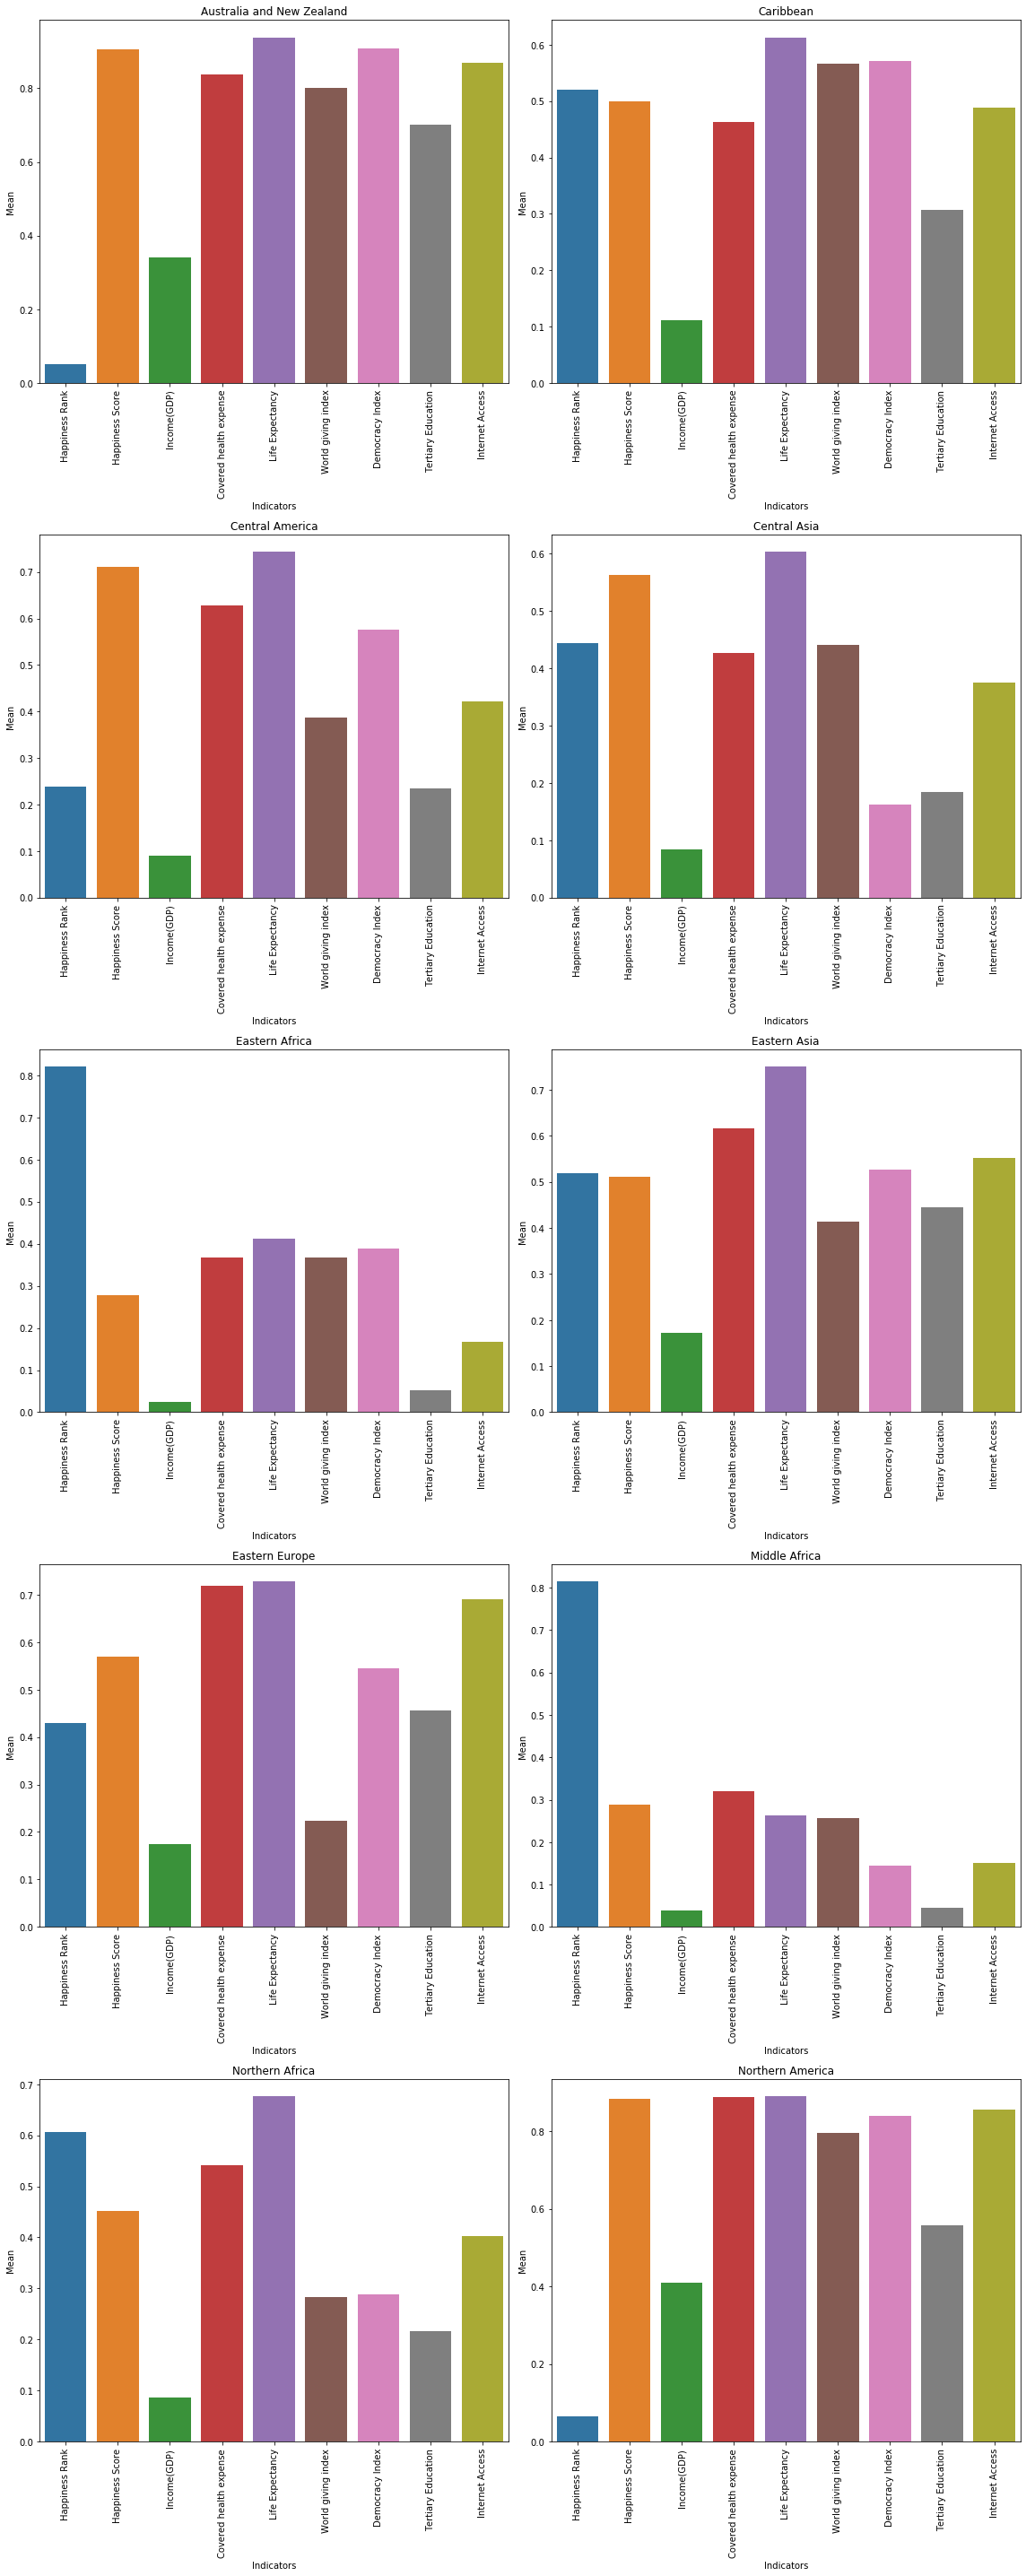

In [38]:
region = list(melt_dict.keys())

fig,ax = plt.subplots(nrows=5,ncols=2,figsize=(16,40));

xlabels = melt_dict['Caribbean']['Indicators'].tolist()

i=0              
for row in range(5):
    for col in range(2):
        b = sns.barplot(x='Indicators',
                        y='Mean',
                        data=melt_dict[region[i]],
                        ax=ax[row,col]).set_title(region[i])
        ax[row,col].set_xticklabels(xlabels,rotation=90)
        plt.tight_layout()
        i+=1
   

### 3.4-Correlations-between-each-indicator-and-happiness-score

Notes:
- For most of the indicators, the bigger value it is, the more positive effect it is for the society. 
- An increase of value for the following indicators will have negative effect:
    - **Number of Homicides**
    - **Gender Inequality(Gini index)** (the bigger the value, the more inequality it is)
    - **Civil Liberties Index** (work like a ranking system from 1-10, smaller number represents more freedom) 
    
Oberservations:
1. For African countries, indicators that show strong corrlation with happiness score fall into lower level of Maslow's pyramid of needs (Income, Covered health expenditure and Life expectancy. Regression lines for all other indicators seem flat, meaning that those factors do not show much impact on happiness level. 
2. For Asian countries, happiness score increase with the gini index increase (more inequality), that is behaving differently compared to the global behavior. 


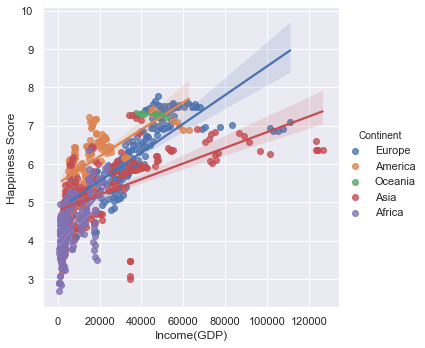

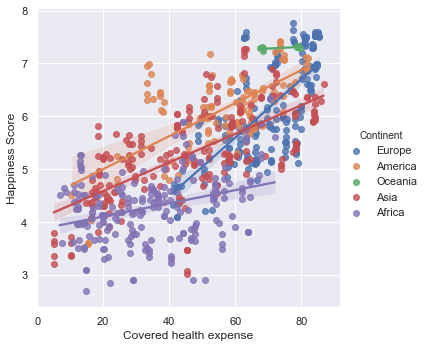

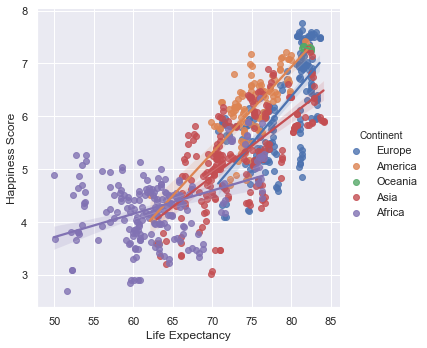

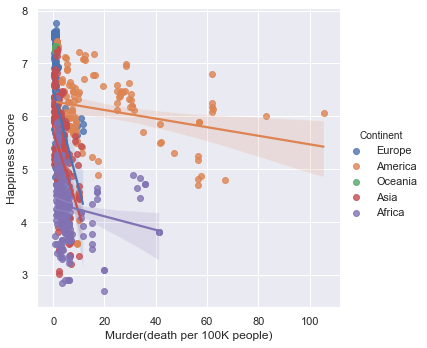

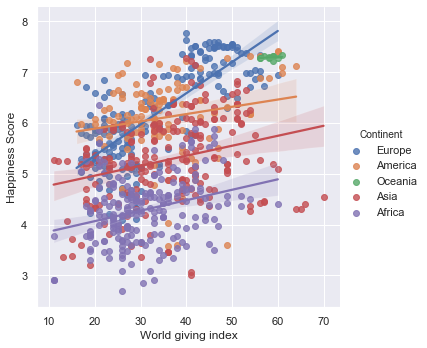

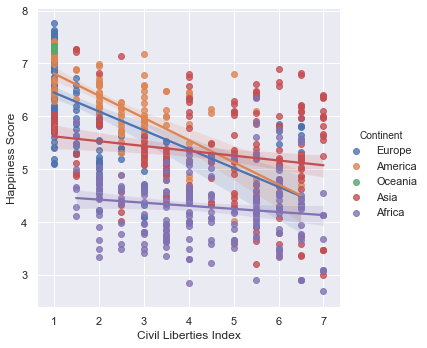

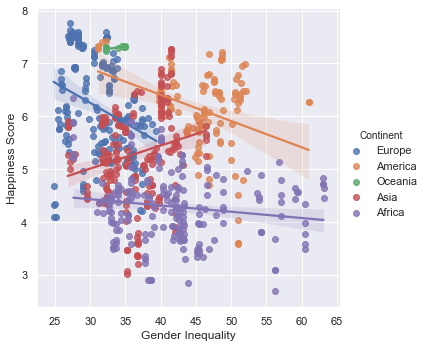

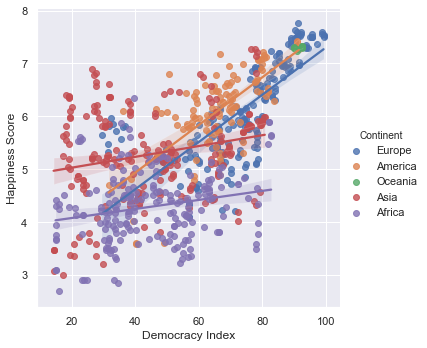

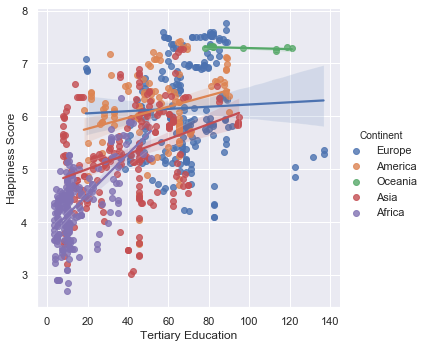

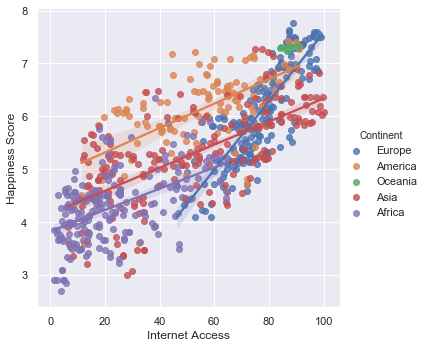

In [39]:
indicators = [col for col in df.columns.tolist() 
              if col not in ['Year','Country','Continent','Region','Happiness Rank','Happiness Score']]

sns.set()

for indicator in indicators:
    g = sns.lmplot(x=indicator,
                   y="Happiness Score",
                   hue="Continent",
                   truncate=True,
                   height=5,
                   data=df,
                   fit_reg=True,)
    g.set_axis_labels(indicator,"Happiness Score")

### 3.5-Correlations-among-indicators

**Oberservations:**

1. Our hypothesis 1 is partially correct that the indicators corresponding to more basic needs have higher correlation with happiness. However the strength of correlations do not straightly follow the sequence of the pyramid above basic needs. 
2. Coverage of Internet Access does have strong correlation with happiness score :))
3. Some of the indicators from the same category are suspected to have strong correlations. We will avoid choosing them as features at the same time when modelling. 
    - Suspected Multicolinearity: 
        1. Income, Covered health expense and Life Expectancy 
        2. Civil Liberties Index and Democracy Index 

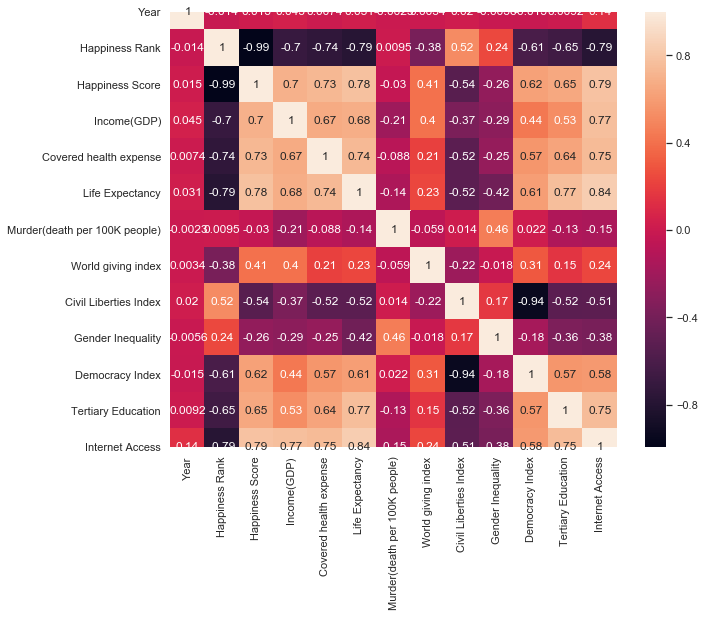

In [40]:
# Use heatmap to show the corrlations among indicators 

fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(df.corr(),annot=True);

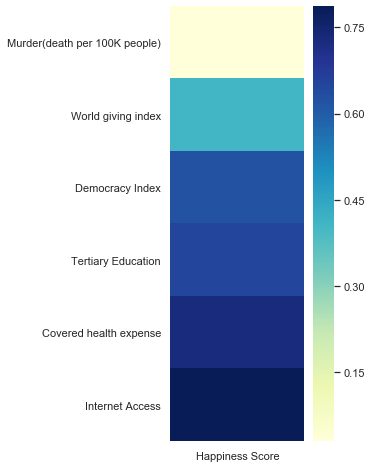

In [41]:
# Absolute value of correlation coefficients between each indicator and happiness score
test = pd.DataFrame(abs(df.corr()['Happiness Score'])
             .sort_values()).drop(['Year','Gender Inequality','Civil Liberties Index','Life Expectancy',
                                   'Income(GDP)','Happiness Rank','Happiness Score'])


fig, ax = plt.subplots(figsize = (3,8))
ax = sns.heatmap(test,cmap='YlGnBu');
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);



## Export combined dataframe 

In [42]:
df.to_csv('./data/combined_df.csv',index=False)